# DAYMET ANNUAL EXAMPLES

This notebook contains the following examples using Dayment Annual dataset. 

- EXAMPLE 0: Accessing the dataset
- EXAMPLE 1: Plotting CA average maximum temperature on 2020
    - Selecting subset from dataset
    - Extracting crs from xarray.DataArray
    - Masking with shapefile
- EXAMPLE 2: Averaging 20 yeras of CA annual mean max temp
    - Selecting data on time range and masking
    - Averaging + Fine tuning attributes
- EXAMPLE 3: Detecting outliers * EXPAND  *
    - Verify outlier existence
    - Map outlier on map
- EXAMPLE 4: Replacing oultiers * TO DO *
- EXAMPLE 5: Grouping values to create categories map 



Following this notebook for Examples 0 - 2.
https://planetarycomputer.microsoft.com/dataset/daymet-annual-na#Example-Notebook

## EXAMPLE 0: Accessing the dataset

In [1]:
# these are libraries for importing data
import pystac
import fsspec
import xarray as xr

# this is for parallel computing
from dask_gateway import GatewayCluster

In [2]:
# accessing collection 
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-annual-na"
collection = pystac.read_file(url)
collection

<Collection id=daymet-annual-na>

In [3]:
# reading from https protocol in zarr format
asset = collection.assets["zarr-https"]
asset

<Asset href=https://daymeteuwest.blob.core.windows.net/daymet-zarr/annual/na.zarr>

In [4]:
# open as xarray dataset
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                  (y: 8075, x: 7814, time: 41, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-07-01T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

In [5]:
# keep attributes throughout opeartions
xr.set_options(keep_attrs=True)

## EXAMPLE 1: Plotting CA maximum 2020 temperature

### STEP 1: selecting subset from previous dataset
We want to examine the mean maximum temperature on 2020. 

To do this we need to subset `ds` (an `xarray.DataSet`) which contains all the data from the Annual Dayment collection. Notice that the resulting subset is type `xarray.Datarray` and has three dimensions: **time**, **y**, and **x**. We will need to squeeze the array to remove the **time** dimension which has constant value 2020 (because we selected that year).  

In [6]:
tmax2020 = ds.sel(time="2020")["tmax"]

# Type is xarray.DataArray
#https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html
print(type(tmax2020))

tmax2020

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'tmax' (time: 1, y: 8075, x: 7814)>
dask.array<getitem, shape=(1, 8075, 7814), dtype=float32, chunksize=(1, 8075, 7814), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-07-01T12:00:00
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: maximum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     annual average of daily maximum temperature
    units:         degrees C

In [7]:
#https://docs.xarray.dev/en/stable/generated/xarray.DataArray.squeeze.html
tmax2020 = tmax2020.squeeze()
tmax2020

<xarray.DataArray 'tmax' (y: 8075, x: 7814)>
dask.array<getitem, shape=(8075, 7814), dtype=float32, chunksize=(8075, 7814), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
    time     datetime64[ns] 2020-07-01T12:00:00
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: maximum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     annual average of daily maximum temperature
    units:         degrees C

### STEP 2: Extracting crs

Pull the Coordinate Reference System (CRS) out from the dataset attributes.

In [8]:
# https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
import cartopy.crs as ccrs

lcc = ds.variables["lambert_conformal_conic"].attrs

prj_kwargs = dict(
    central_latitude=lcc["latitude_of_projection_origin"],
    central_longitude=lcc["longitude_of_central_meridian"],
    standard_parallels=(lcc["standard_parallel"]),
)
crs = ccrs.LambertConformal(**prj_kwargs)

crs

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +lon_0=-100.0 +lat_0=42.5 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### STEP 3: Masking

1. Import the CA shapefile as a `geopandas.GeoDataFrame` using `geopandas` library
2. Match CRS of shapefile and xarray
3. Mask

epsg:3857
<class 'geopandas.geodataframe.GeoDataFrame'>


<AxesSubplot:>

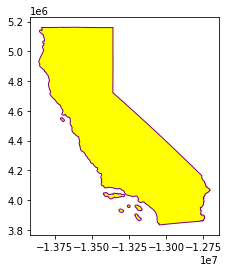

In [9]:
import geopandas as gpd

ca_shape_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)
print(ca_shape.crs)
print(type(ca_shape))
ca_shape.plot(edgecolor='purple', color='yellow')

<AxesSubplot:>

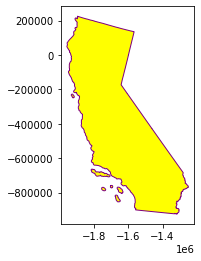

In [10]:
# match CRS
ca_lambert = ca_shape.to_crs(crs)
ca_lambert.plot(edgecolor='purple', color='yellow')

We want to use `rasterio` package to mask `tmax2020`. To do this we need to write the `crs` we extracted as a crs into `tmax2020`. Then we can use the `ca_lambert` to maks the raster. Notice we can already tell the masking did something because the dimensions of the `clipped` subset are a lot smaller that the original one: (y: 1149, x: 706) vs (y: 8075, x: 7814).

In [11]:
import rasterio as rio

tmax2020_crs = tmax2020.rio.write_crs(crs)

In [12]:
clipped = tmax2020_crs.rio.clip(ca_lambert.geometry, 
                              ca_lambert.crs)
clipped

<xarray.DataArray 'tmax' (y: 1149, x: 706)>
dask.array<copy, shape=(1149, 706), dtype=float32, chunksize=(1149, 706), chunktype=numpy.ndarray>
Coordinates:
  * y                        (y) float64 2.24e+05 2.23e+05 ... -9.24e+05
  * x                        (x) float64 -1.955e+06 -1.954e+06 ... -1.25e+06
    lat                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    time                     datetime64[ns] 2020-07-01T12:00:00
    lambert_conformal_conic  int64 0
Attributes:
    cell_methods:  area: mean time: maximum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     annual average of daily maximum temperature
    units:         degrees C

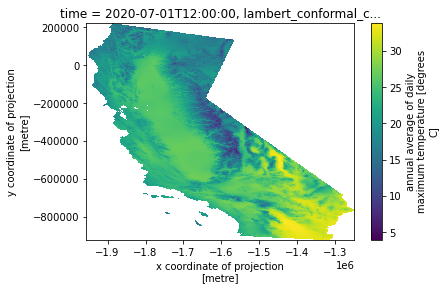

In [13]:
clipped.plot()

In [14]:
# These are the first steps of something else I tried for masking but did did not work. 

# https://gis.stackexchange.com/questions/357490/mask-xarray-dataset-using-a-shapefile

#CAmask = rio.features.geometry_mask(ca_lambert['geometry'][0],
#                                    out_shape=(len(tmax2020.y), len(tmax2020.x)),
#                                    transform= ca_lambert.affine_transform(),
#                                    all_touched = True,
#                                    invert=True)

## EXAMPLE 2: Averaging 20 yeras of CA annual mean max temp

For this example the steps will be a bit different. If we try to average first and then maks then it will take much longer because we would be averaging all the North America data. Instead we will mask first and average second. 

The commented cells below show how it would look like to average first and mask later. It is interesting to not that when running everything but the plotting is very fast -- that is because there are actually no computations being performed yet!! As far as I know everything here works "lazily", meaning it does not compute anything until it absolutely has to (ex: for plotting).

In [15]:
# avg2020 = ds.sel(time=slice("2000","2020"))["tmax"].mean(dim="time")

# avg2020_crs = avg2020.rio.write_crs(crs)

# avg2020_CA = avg2020_crs.rio.clip(ca_lambert.geometry,
#                                   ca_lambert.crs)

In [16]:
# avg2020_CA.plot()

### Step 1: selecting data on time range and masking
Notice we will use `slice` within the `sel()` function because we are interested in a time range. Also notice that there are 20 chunks in this array, each corresponding to a year. 


After averaging we obtain an `xarray.DataArray` that is already 2-dimensional. 

In [17]:
years = ds.sel(time=slice("2001","2020"))["tmax"]
years

<xarray.DataArray 'tmax' (time: 20, y: 8075, x: 7814)>
dask.array<getitem, shape=(20, 8075, 7814), dtype=float32, chunksize=(1, 8075, 7814), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
  * time     (time) datetime64[ns] 2001-07-02T12:00:00 ... 2020-07-01T12:00:00
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: maximum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     annual average of daily maximum temperature
    units:         degrees C

To do the masking we need to 
1. set crs to years `xarray.DataArray`
2. mask

We will use the same `crs` we had extracted before and the CA boundary that matches. Notice that the resulting `xarra.DataArray` has the same **x**, **y** as the previous CA raster we computed.

In [18]:
years = years.rio.write_crs(crs)
years_ca = years.rio.clip(ca_lambert.geometry, ca_lambert.crs)
years_ca

<xarray.DataArray 'tmax' (time: 20, y: 1149, x: 706)>
dask.array<getitem, shape=(20, 1149, 706), dtype=float32, chunksize=(1, 1149, 706), chunktype=numpy.ndarray>
Coordinates:
  * y                        (y) float64 2.24e+05 2.23e+05 ... -9.24e+05
  * x                        (x) float64 -1.955e+06 -1.954e+06 ... -1.25e+06
    lat                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2001-07-02T12:00:00 ... 20...
    lambert_conformal_conic  int64 0
Attributes:
    cell_methods:  area: mean time: maximum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     annual average of daily maximum temperature
    units:         degrees C

### STEP 2: Averaging + Fine Tuning Attributes
First we average and plot. Notice the legend on the RHS of the plot: it is still talking about annual maverage of daily max temperature even though we are not looking at that any more. We need to update the array's attributes! The attributes in an `xarray.DataArray`form a dictionary that contains arbitrary metadata.

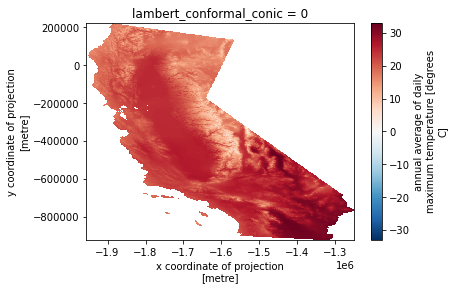

In [19]:
ca_tmax_20yravg = years_ca.mean(dim="time")
ca_tmax_20yravg.plot()

Let's update the attributes. First we accesss the attributes dictionary using `xarray.DataArray.atts`. 
We can see the 'long_name' attribute is the legend we would like to update. And while we're at it, we will also drop the 'cell_methods' attribute (not really sure what it is for!).

In [20]:
ca_tmax_20yravg.attrs

{'cell_methods': 'area: mean time: maximum within days time: mean over days',
 'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'annual average of daily maximum temperature',
 'units': 'degrees C'}

In [21]:
ca_tmax_20yravg.attrs['long_name']= 'average of maximum temperature from 2001 to 2020'
ca_tmax_20yravg.attrs.pop('cell_methods')

'area: mean time: maximum within days time: mean over days'

In [22]:
ca_tmax_20yravg.attrs

{'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'average of maximum temperature from 2001 to 2020',
 'units': 'degrees C'}

## EXAMPLE 3: Detecting outliers

Notice that in the previous plot everything looks really red! Which makes us think there must be an outlier squishing together these 20 year average of max temp. Here we will try to find, locate on the map and replae this oulier with the average of its neighbours. 

### Step 1: verify there is an outlier.
It seems unlikely that the max average temperature would fall below 0 C, so we will falg any negative value as an oulier. Indeed, when we remove the negative values using `xarray.DataArray.where()` we obtain a much more reasonable temperature distribution.

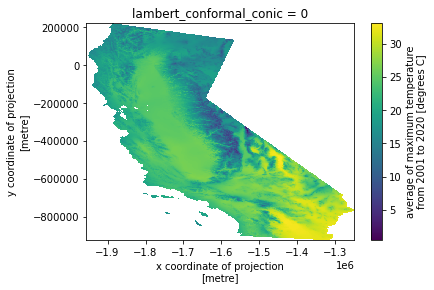

In [23]:
#https://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html
good_pts = ca_tmax_20yravg.where(ca_tmax_20yravg>0)
good_pts.plot()

Next we can find the outlier/s. Notice the resulting DataArray has 1x1 dimension, meaning there is a single outlier. When we use `np.unique` we can see that the outlier value is -0.1379054.

In [24]:
import numpy as np

outliers = ca_tmax_20yravg.where( ca_tmax_20yravg<0, drop=True )

print(np.unique(outliers.to_series()))

print(type(outliers))
outliers

[-0.1379054]
<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'tmax' (y: 1, x: 1)>
dask.array<where, shape=(1, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * y                        (y) float64 -3.47e+05
  * x                        (x) float64 -1.531e+06
    lat                      (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lambert_conformal_conic  int64 0
Attributes:
    grid_mapping:  lambert_conformal_conic
    long_name:     average of maximum temperature from 2001 to 2020
    units:         degrees C

### STEP 2: Locate on the map
We plan to use the `opencv` library to enlarge the pixels that have outliers. This will be a bit of a multistep process. 

1. Use `xarray.DataArray.where` to convert the `ca_avg` DataArray into one that has 1 on the outliers and 0 on the non-outliers.
2. Use `cv2.dilate()` to thicken the pixels with outliers. Notice that openCV only takes numpy.DataArrays, so we need to convert the ouliers xarray.DataArray using  `xarray.DataArray.to_numpy()`. The result from `cv2.dilate()` will be a numpy.DataArray.
3. Transform the result from the previous result into a xarray.DataArray with the same dimensions, coordinates and attributes as `ca_avg`. 

In [25]:
# Get binary DataArray
outliers = ca_tmax_20yravg.where( ca_tmax_20yravg<0, 0)
outliers = outliers.where( outliers== 0, 1)

print(np.unique(outliers.to_numpy()))
outliers

[0. 1.]


<xarray.DataArray 'tmax' (y: 1149, x: 706)>
dask.array<where, shape=(1149, 706), dtype=float32, chunksize=(1149, 706), chunktype=numpy.ndarray>
Coordinates:
  * y                        (y) float64 2.24e+05 2.23e+05 ... -9.24e+05
  * x                        (x) float64 -1.955e+06 -1.954e+06 ... -1.25e+06
    lat                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lambert_conformal_conic  int64 0
Attributes:
    grid_mapping:  lambert_conformal_conic
    long_name:     average of maximum temperature from 2001 to 2020
    units:         degrees C

In [26]:
# # Dilate oulier pixels

# import cv2
# from rasterio.plot import show

# kernel = np.ones((30,30), np.uint8)
# thick_outliers = cv2.dilate(outliers.to_numpy(), kernel, iterations=1)

# print(type(thick_outliers))
# show(thick_outliers)

In [27]:
# # Go back to xarray.

# thick_outliers_XA = xr.DataArray(
#     data= thick_outliers,
#     dims= ca_tmax_20yravg.dims,
#     coords= ca_tmax_20yravg.coords,
#     attrs= ca_tmax_20yravg.attrs
#     )

# thick_outliers_XA

In [28]:
# # ---- CREATE MAP ----

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize = (10,10))
# thick_outliers_XA.plot(ax=ax)
# ca_lambert.plot(ax=ax,edgecolor='yellow', facecolor="none")
# #CA_shp.plot(ax=ax, color='lightgray')
# #geo_pigs.plot(ax=ax, alpha=0.2)



## EXAMPLE 4: Replacing outliers

https://www.youtube.com/watch?v=CLg1vwv-nJI

https://scipython.com/book/chapter-8-scipy/examples/two-dimensional-interpolation-with-scipyinterpolategriddata/

https://stackoverflow.com/questions/37662180/interpolate-missing-values-2d-python

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

https://xarray.pydata.org/en/stable/generated/xarray.DataArray.interpolate_na.html

https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/

In [29]:
# import numpy as np
# from scipy import interpolate


# #Let's create some random  data
# array = np.random.randint(0,10,(10,10)).astype(float)
# #values grater then 7 goes to np.nan
# array[array>7] = np.nan
# array

In [30]:
# x = np.arange(0, array.shape[0])
# y = np.arange(0, array.shape[1])
# xx, yy = np.meshgrid(x, y)

## EXAMPLE 5: Grouping Values

We are interested in grouping values of the temperature to obtain regions in the map. We will do this in the following way:

1. establish thresholds 
2. extract the xarray.DataArray's array as a `numpy.ndarray`
3. use `numpy.where` to group into regions
4. create a new `xarray.DataArray` from the `numpy.ndarray` we created

After this we need to update the attributes of the categories xarra.Datarray, we will create a new attribute holding the information about each region code. 

### FIRST TRY: incorrect!
There is something sneaky here, and justb y looking at the output map we might not detect it. When we check the unique values of the array after reclassifying we can see that there are only regions 3-6, no pixel is classified as 2. It might very well be that there are no pixels less tha 0, but also our code is not really doing what we intend to. 

When we run the first line `tmax_rgns[np.where( tmax_rgns< k[0])] = 2` the pixels that were less than 0 now have value 2, which is in between 0 and 10. So on the second line `tmax_rgns[np.where( (k[0]<=tmax_rgns) & (tmax_rgns<k[1]))] = 3` the pixels that were less than 0 are now reclassified as 3. X__X By swapping the first two lines we get the correct code.

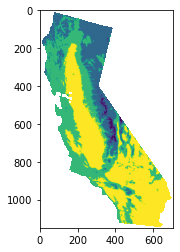

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# extract numpy.ndarray
tmax_rgns = ca_tmax_20yravg.to_numpy()
# establish thresholds
k = [0,10,18,24]

tmax_rgns[np.where( tmax_rgns< k[0])] = 2
tmax_rgns[np.where( (k[0]<=tmax_rgns) & (tmax_rgns<k[1]))] = 3
tmax_rgns[np.where( (k[1]<=tmax_rgns) & (tmax_rgns<k[2]))] = 4
tmax_rgns[np.where( (k[2]<=tmax_rgns) & (tmax_rgns<k[3]))] = 5
tmax_rgns[np.where(k[3]<=tmax_rgns)] = 6

plt.imshow(tmax_rgns)

In [32]:
tmax_rgns = tmax_rgns[~np.isnan(tmax_rgns)] #remove nan
print(np.unique(tmax_rgns))

[3. 4. 5. 6.]


### SECOND TRY

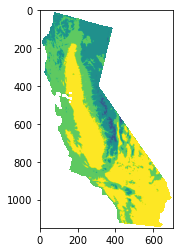

In [33]:
tmax_rgns = ca_tmax_20yravg.to_numpy()
# establish thresholds
k = [0,10,18,24]

tmax_rgns[np.where( (k[0]<=tmax_rgns) & (tmax_rgns<k[1]))] = 3
tmax_rgns[np.where( tmax_rgns< k[0])] = 2
tmax_rgns[np.where( (k[1]<=tmax_rgns) & (tmax_rgns<k[2]))] = 4
tmax_rgns[np.where( (k[2]<=tmax_rgns) & (tmax_rgns<k[3]))] = 5
tmax_rgns[np.where(k[3]<=tmax_rgns)] = 6

plt.imshow(tmax_rgns)

#tmax_rgns = tmax_rgns[~np.isnan(tmax_rgns)] #remove nan
#print(np.unique(tmax_rgns))Although it is hard to realize something changed by looking at the map, we can see that there are now pixels with value 2. 

In [35]:
copy= tmax_rgns
copy = copy[~np.isnan(copy)] #remove nan
print(np.unique(copy))

[2. 3. 4. 5. 6.]


Next we move on to converting the np.array into xarray.DataArray. When doing this we want to add some descriptive attributes, including what each region code (1,2,3) means. 

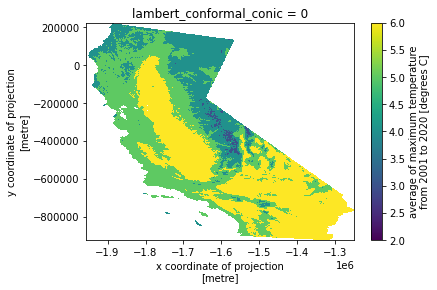

In [36]:
# create xarray.DataArray with np.ndarray
ca_tmax_regions = xr.DataArray(
    data= tmax_rgns,
    dims= ca_tmax_20yravg.dims,
    coords= ca_tmax_20yravg.coords,
    attrs= ca_tmax_20yravg.attrs
    )

ca_tmax_regions.plot()

In [37]:
# UPDATE ATTRIBUTES
ca_tmax_regions.attrs

{'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'average of maximum temperature from 2001 to 2020',
 'units': 'degrees C'}

On my first try I saved the region codes as a dictionary. This will work ok as long as you do not export it, because netCDF files won't allow having a dict as an attribute. So we will save each code separately.

In [ ]:
# d = { 2: 'temp less than '+str(k[0]) ,
#     3: 'temp in ['+str(k[0])+','+str(k[1])+')',
#     4: 'temp in ['+str(k[1])+','+str(k[2])+')',
#     5: 'temp in ['+str(k[2])+','+str(k[3])+')',
#     6: 'temp geq than '+str(k[3]) } 
# ca_tmax_regions.attrs['regions_codes'] = d
# ca_tmax_regions.attrs

In [41]:
ca_tmax_regions.attrs.pop('units')
ca_tmax_regions.attrs['long_name'] = 'discretization of average max temperature 2001-2020'

ca_tmax_regions.attrs['region_2']= 'temp less than '+str(k[0])
ca_tmax_regions.attrs['region_3']= 'temp in ['+str(k[0])+','+str(k[1])+')'
ca_tmax_regions.attrs['region_4']= 'temp in ['+str(k[1])+','+str(k[2])+')'
ca_tmax_regions.attrs['region_5']= 'temp in ['+str(k[2])+','+str(k[3])+')'
ca_tmax_regions.attrs['region_6']= 'temp geq than '+str(k[3])

{'grid_mapping': 'lambert_conformal_conic',
 'long_name': 'discretization of average max temperature 2001-2020',
 'region_2': 'temp less than 0',
 'region_3': 'temp in [0,10)',
 'region_4': 'temp in [10,18)',
 'region_5': 'temp in [18,24)',
 'region_6': 'temp geq than 24'}

In [42]:
ca_tmax_regions

<xarray.DataArray (y: 1149, x: 706)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y                        (y) float64 2.24e+05 2.23e+05 ... -9.24e+05
  * x                        (x) float64 -1.955e+06 -1.954e+06 ... -1.25e+06
    lat                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lambert_conformal_conic  int64 0
Attributes:
    grid_mapping:  lambert_conformal_conic
    long_name:     discretization of average max temperature 2001-2020
    region_2:      temp less than 0
    region_3:      temp in [0,10)
    region_4:      temp in [10,18)
    region_5:      temp in [18,24)
    region_6:      temp geq than 24